# Stock Market Analysis

**Brian West, David Samuel, Kumar Raja Guvindan Raju**

# Pulling Data

Below is the code that was used to pull the data from TDAmeritrade. The actual `tda` module is a custom API for interacting with the proprietary TDAmeritrade API, so it will not work on other systems, therefore the end of this segment will save the data to a CSV file.

Note that we specify January 1, 1950 as the starting date. However, the API does not support data retrieval past a certain point, so it will automatically cap the lookback. However, this ensures that we can maximum possible amount of data.

**This code will not work if you do not happen to have this "tda" module, which is not available. Skip to the "Reloading the Data" section!!**

In [ ]:
import pandas as pd

sp_500_index = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', header=0)[0]

This should pull the entire list of tickers that are currently listed on the S&P 500 index. Fun fact, due to the index's methodology, this actually lists 505 tickers because some companies are listed multiple times. For example, Comcast is the parent of NBC Universal and CNBC.

In [ ]:
print('How many stocks do we have? (This better be 505!): {}'.format(sp_500_index.shape[0]))
sp_500_index.columns = ['Symbol', 'Name', 'SEC', 'Sector', 'Industry', 'Headquarters', 'Listed', 'CIK']
sp_500_index.head()

In [ ]:
import tda

tda_session = tda.TDASession(app_name="Unit_4_Case_Study")

Unfortunately, due to an error within the TDAmeritrade API, some data does not pull correctly, so we cannot pull data in bulk.

In [ ]:
bad_requests = []
historical_data = {}

for ticker in sp_500_index.Symbol:
    results = tda_session.getHistorical(ticker, '19500101', '20170531')
    if results == {}:
        bad_requests.append(ticker)
    else:
        historical_data[ticker] = results[ticker]['prices']

In [ ]:
historical_data = {k: v for k, v in historical_data.items() if len(v) >= 90}

Some of our symbols contain only a few days of data, so we will ignore any tickers that do not contain at least 90 days of prices.

In [ ]:
bad_requests

BRK.B refers to Berkshire Hathaway Class B shares, and BF.B corresponds to Brown-Forman Class B shares. Let's write out the list of good tickers to a CSV.

In [ ]:
sp_500_index = sp_500_index[sp_500_index.Symbol.isin(historical_data.keys())]
sp_500_index.to_csv('GoodSP500Symbols.csv', index=False)

## Formatting into a data frame

The data that comes back from the API is in a messy dictionary of symbols mapping to lists of daily information. Each day contains the open, low, high, close, and total volume for the symbol, along with a timestamp.

To format the data, we need to pre-allocate a `numpy` matrix. Otherwise, the data manipulation will be unreasonably slow. Each stock will of course have a different historical availability, so we need to create a matrix that will hold all records for the symbol with the most days available.

In [ ]:
oldest_ticker = max(historical_data.keys(), key=lambda t: len(historical_data[t]))
max_len = len(historical_data[oldest_ticker])
print('"{}" has the most days with {} records'.format(oldest_ticker, max_len))

youngest_ticker = min(historical_data.keys(), key=lambda t: len(historical_data[t]))
min_len = len(historical_data[youngest_ticker])
print('"{}" has the least days with {} records'.format(youngest_ticker, min_len))

print('')
print('We have a total of {} valid symbols'.format(len(historical_data.keys())))

This tells us that we need an empty (`NaN` filled) matrix of shape `(7666, 499)` and then we need to allocate the records to it.

In [ ]:
import numpy as np

all_tickers = sorted(historical_data.keys())
variables = ['open', 'low', 'high', 'close', 'volume']

price_matrix = np.full((max_len, 5 * len(all_tickers)), np.nan)
print(price_matrix.shape)
price_matrix

One thing we need to verify is that all the days are aligned such that the last record for each symbol is on the same day. This will make it much easier to align the information in the matrix.

In [ ]:
from datetime import *

last_date = date.fromtimestamp(historical_data[oldest_ticker][-1]['timestamp'] / 1000)
for k, v in historical_data.items():
    if date.fromtimestamp(v[-1]['timestamp'] / 1000) != last_date:
        print(k)

Because we don't see any output here, we can be sure that all the data has an endpoint of May 31, 2017. This means that we can fill the matrix from the bottom up and simply align the last record of each symbol to the last row of the price matrix.

In [ ]:
for i, ticker in enumerate(all_tickers):
    records = historical_data[ticker]
    record_count = len(records)
    for j, variable in enumerate(variables):
        price_matrix[-record_count:, 5*i + j] = [record[variable] for record in records]

This gives us a full matrix of all the data available for each ticker on a daily basis.

In [ ]:
column_names = ['%s_%s' % (ticker, variable) for ticker in all_tickers for variable in variables]
column_names[0:20]

In [ ]:
price_df = pd.DataFrame(price_matrix, columns=column_names)
price_df.tail()

In [ ]:
price_df.to_csv('FullPriceData.csv', index=False)

## Reloading the data

The data has now been saved into a large CSV file for portability. The block below will load both CSV files and import the libraries so that the above section is not needed.

In [1]:
import pandas as pd
import numpy as np
from datetime import *

sp_500_index = pd.read_csv('GoodSP500Symbols.csv', header=0, encoding="ISO-8859-1")
price_df = pd.read_csv('http://www.dropbox.com/s/sz01zcjbvhrllf7/FullPriceData.csv?dl=1', header=0)

all_tickers = sorted(sp_500_index.Symbol)
variables = ['open', 'low', 'high', 'close', 'volume']

In [2]:
sp_500_index.head()

,Symbol,Name,SEC,Sector,Industry,Headquarters,Listed,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [6]:
price_df.head()

,A_open,A_low,A_high,A_close,A_volume,AAL_open,AAL_low,AAL_high,AAL_close,AAL_volume,...,ZION_open,ZION_low,ZION_high,ZION_close,ZION_volume,ZTS_open,ZTS_low,ZTS_high,ZTS_close,ZTS_volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Build cross-correlation

The next step is to construct the correlation matrix for all stocks. To do this, we want to compute the intracorrelation for each ticker based on the days in which we have prices for both symbols. This means that we need to compute the daily percent changes for each symbol, then compute a correlation coefficient between the two price change histories.

To compute the correlation, we will compute the correlations between daily percent changes in open, low, high, and close prices, then take the average of the correlation coefficients.

**This correlation matrix takes an extremely long time to build because it has approximately 1,000,000 correlations to compute. The end of this section has a load call to load a saved version.**

In [ ]:
def get_correlation(one, two):
    one = one[~np.isnan(one)]
    two = two[~np.isnan(two)]
    
    # While unlikely for S&P 500 stocks, if a symbol is not
    # traded on a given day, the API reports 0 for the prices
    one.ix[one == 0] = np.nan
    two.ix[two == 0] = np.nan
    
    # Fill the new NaN values with the preceding non-NaN value
    one = one.fillna(method='ffill')
    two = two.fillna(method='ffill')
    
    one = one[~np.isnan(one)]
    two = two[~np.isnan(two)]
    
    one = one.pct_change()[1:]
    two = two.pct_change()[1:]
    
    correlation = np.corrcoef(one[-min(len(one), len(two)):], two[-min(len(one), len(two)):]).reshape(-1)[1]
    if np.isnan(correlation):
        raise Exception("NaN correlation")
    
    return correlation**2

This creates a matrix in which each entry is the $R^2$ correlation between the two stocks. So, the entry at $C_{i,j}$ shows the $R^2$ for the daily percent changes between stocks `i` and `j`.

In [ ]:
correlation_matrix = np.identity(len(all_tickers))
temp = '%s_%s'

for i in range(len(all_tickers)):
    t1 = all_tickers[i]
    for j in range(i+1, len(all_tickers)):
        t2 = all_tickers[j]
        corr = np.array([get_correlation(price_df[temp % (t1, v)], price_df[temp % (t2, v)]) for v in variables[:-1]]).mean()
        correlation_matrix[i, j] = corr
        correlation_matrix[j, i] = corr

In [ ]:
correlation_matrix

In [ ]:
np.save('correlation_matrix.npy', correlation_matrix)

### Load the correlation matrix from file

Given that the correlation matrix can take an extremely long time to load, I have saved it to a `.npy` file that can easily be loaded.

In [7]:
import numpy as np

correlation_matrix = np.load('correlation_matrix.npy')

# Cluster Stocks by Correlation Matrix

Spectral clustering is an effective way to compute clusters so long as there is a well-defined, positive 

In [8]:
from sklearn.cluster import SpectralClustering

n_clusters = sp_500_index.Industry.unique().shape[0]
spectral = SpectralClustering(n_clusters=n_clusters, affinity="precomputed")
cluster_ids = pd.Series(spectral.fit_predict(correlation_matrix))

# A Novel Trending Detection Algorithm

Autocorrelation can be useful for detecting the seasonality of a time series. However, it is not entirely useful for determining longer term trends. For this, we introduce a novel trend detection algorithm for identifying whether a time series tends to have a trend over a given lag time. This can be done iteratively over several lag times to detect the optimal lag time for trends in the time series.

For our initial demonstration, we will use IBM closing prices as the time series.

The first step for trend detection is to compute the mean and standard deviation of the daily returns.

In [9]:
# This provides the utility used in the get_correlation function to remove the 0 values that are
# used when a stock is not traded on a given market open day.
def fix_ts(ts):
    ts = ts[~np.isnan(ts)]
    ts.ix[ts == 0] = np.nan
    ts = ts.fillna(method='ffill')
    ts = ts[~np.isnan(ts)]
    return ts

In [10]:
ibm_ts = fix_ts(price_df['IBM_close'])
mean_ibm = ibm_ts.diff()[1:].mean()
std_ibm = ibm_ts.diff()[1:].std()

In [11]:
import math

print('IBM daily mean: {}'.format(mean_ibm))
print('IBM daily std : {}'.format(std_ibm))

print()
print('Daily Sharpe: {}'.format(mean_ibm / std_ibm))
print('Annual Sharpe: {}'.format(252 * mean_ibm / (math.sqrt(252) * std_ibm)))

IBM daily mean: 0.02279141117193378
IBM daily std : 1.7525834400149858

Daily Sharpe: 0.013004465665691158
Annual Sharpe: 0.20643949250818097


The trend detection algorithm relies on the random walk theory. Random walk theory states that the share price of a company is unpredictable on a day-to-day basis. If this is true, then the cumulative changes experienced over n-days should be a random sample from the distribution of price changes (which can be performed via a Monte Carlo simulation such as Metropolis-Hastings).

If we can assume that the daily price changes follow a normal distribution, then we can expect that the standard deviation over n-days is $\mu / \sqrt(n)$ per day, which becomes a cumulative expected change of $\sqrt(n) \cdot \mu$.

In our example, we make a few dangerous assumptions for ease of explanation and simplification of math:

* We assume a normal distribution, which is not a good description for the daily price changes of a stock.
* We are using the daily absolute change in price. Over the short term, we expect that this is reasonable because cumulative percent changes will not have taken effect. Over the long term, the product of the daily percent differences is a more accurate description of the movement of stock price.

First we define a function to determine the standard deviation of changes over a given lag period. We assume that the mean daily change is the same for these time periods, and therefore can be assumed as $t \cdot \mu$

In [12]:
def trending_sigma(x, t=1):
    x = x.values.reshape(-1)
    ts = x[t:len(x)] - x[0:len(x)-t]
    return math.sqrt((((mean_ibm * t) - ts)**2).sum() / len(ts))
    #return ts.std()

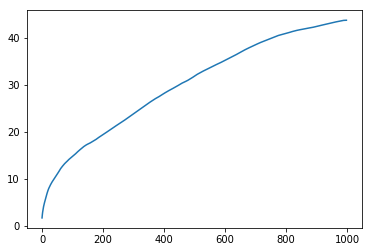

In [13]:
trending_std = np.array([trending_sigma(ibm_ts, t=t) for t in range(1, 1000)])

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(trending_std)

We expect that the above graph should roughly follow a square root growth in standard deviation. We can use this to compute the percentage of variance that is removed over the given time period to determine whether the stock truly follows a random walk over a set distribution.

To determine the percentage of variation relative to the expected variation over the time frame, we identify the true variation over a given time scale (which is given by the trending_std entry squared by the expected variation, which should be $(\sqrt(n) \cdot \sigma_{t=1})^2 = n \cdot sigma_{t=1}^2$. We then subtract this value from 1 to determine the percentage of the expected variance that was removed over that time frame relative to a random walk.

Best trend: 251 days


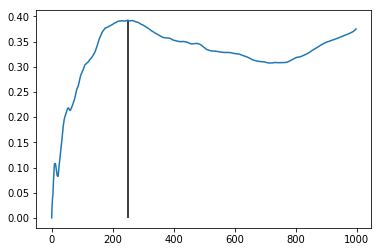

In [14]:
import math

def expected_var(std, t=1):
    return (math.sqrt(t) * std)**2

trending_rsquared = np.array([1. - t_std**2 / expected_var(std_ibm, t=t+1) for t, t_std in enumerate(trending_std)])
largest = np.argmax(trending_rsquared)
print('Best trend: {} days'.format(largest + 1))
plt.plot(trending_rsquared)
plt.vlines(largest, ymin=0, ymax=trending_rsquared[largest])

This tells us that we see a distinct annual trend that reduces the volatility of the IBM closing price changes by approximately 40% relative to what we would expect assuming a random walk theory.

## Assessing profitability

If we see evidence of trending over a given time frame, then we should expect that an exponential moving average over the time frame should show a smooth detection of a trend in the stock price.

Our "trading rule will be a simple exponential moving average over the past `t` days to produce the current trend. Our assumption is that the evidence of trending implies that a mean reversion should occur. Therefore, as the price moves above the exponential moving average, we expect that the trend's strength is unsustainably high (given the 40% reduction in variance over a year's time relative to the expected) and we sell short. If the price moves below the trend line, we expect that it is swinging too low (again, the variance is far below expected, which suggests that too many people are simply "following the market").

Common practice when implementing trading rules and automated forecasts is to convert binary decisions (above or below the exponential moving average) into continuous values. In this case, a good approach is to find the standard deviation of the price relative to the moving average and then divide new differences by the standard deviation to get a z-score. We can interpret the z-score as the percentage of capital that should be allocated into the stock. A z-score of 0.65 indicates that we should be long with 65% of our trading capital and a z-score of -0.65 indicates that we should be short the same amount. Values outside -1 to 1 indicate the use of leverage.

It is also common to cap the values at -2 to 2 to prevent over-leverage and over-confidence of the rules. We will also cap our short sells at -1 to account for the inherent extra risk of selling short.

To calculate our scaling factor, we find the standard deviaton relative to the moving average for the first 2000 days and then multiply it by an additional 1.5 to provide an extra dose of caution.

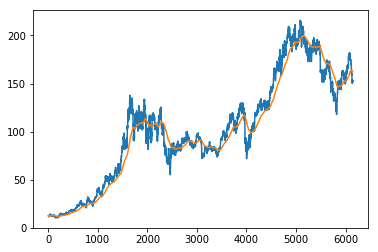

In [23]:
time_scale = 252
ibm_ema = ibm_ts.ewm(span=time_scale, min_periods=0,adjust=True,ignore_na=False).mean()
#ibm_sma = pd.rolling_mean(ibm_ts, window=time_scale)

plt.plot(ibm_ts.values)
plt.plot(ibm_ema.values)

In [24]:
n_cal = 2000
calibration = (ibm_ts.values - ibm_ema.values)[:n_cal]
scaler = 1.5 * math.sqrt(np.sum((0 - calibration)**2) / calibration.shape[0])

get_allocation = lambda i: -1 * (ibm_ts.values[n_cal + i] - ibm_ema.values[n_cal + i]) / scaler
#get_allocation = lambda i: (ibm_ts.val)

allocations = np.array([get_allocation(i) for i in range(len(ibm_ema.values) - n_cal)])[:-1]
allocations = np.clip(allocations, -1, 2)

ibm_test = pd.Series(ibm_ts.values).pct_change().values[n_cal + 1:]

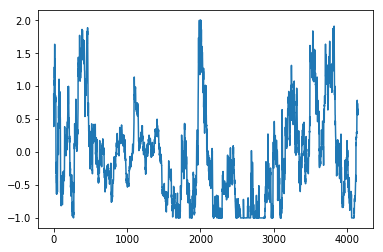

In [25]:
plt.plot(allocations)

Now that we have the allocation at any given time, shifted relative to the percent change that allocation would experience (the two time series are one day offset from each other, so that an allocation decision at Monday's close price is aligned with the percent change from Monday to the close of Tuesday. This allows us to compute the daily percent change experienced adjusted for the allocation that was made for that day.

In [26]:
daily_changes = []

for i in range(len(ibm_test)):
    change = allocations[i] * ibm_test[i]
    daily_changes.append(change)
    
daily_changes = np.array(daily_changes)

We can then look at a graph of the daily changes and compute our expected Sharpe ratio.

Daily changes mean: 0.00026932379453425346
Daily changes Sharpe: 0.018513760004193282
Annual Sharpe: 0.2938968288229773


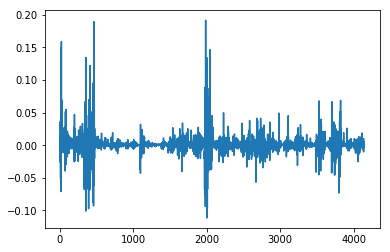

In [27]:
print('Daily changes mean: {}'.format(daily_changes.mean()))
print('Daily changes Sharpe: {}'.format(daily_changes.mean() / daily_changes.std()))
print('Annual Sharpe: {}'.format(252 * daily_changes.mean() / (math.sqrt(252) * daily_changes.std())))
plt.plot(daily_changes)

In [28]:
print(min(daily_changes))
print(max(daily_changes))

-0.111359833855
0.191312949206


The cumulative product of the daily changes can be used to compute the cumulative growth of our capital.

Final growth: 0.9864789308191246


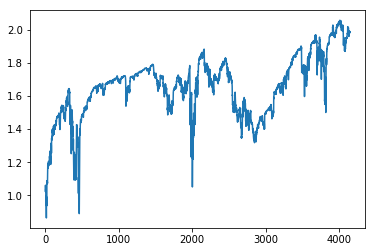

In [29]:
cumulative_growth = (daily_changes + 1).cumprod()

print('Final growth: {}'.format(cumulative_growth[-1] - 1))
plt.plot(cumulative_growth)

And we can compare the starting value of our time period and the ending value to determine the success of a buy and hold strategy.

In [30]:
ibm_ts.values[-1] / ibm_ts.values[n_cal]

1.5961307700163399

Over approximately 16 years, we show approximately 100% growth using this strategy, which equates to roughly 5% per year. Over the same time period, we would see a 59% return from buying and holding IBM. This implies an alpha roughly doubling the market performance by identifying the trends that tend to occur over a year. We also see that a Sharpe ratio of 0.20 for a buy and hold strategy is improved to a ratio of 0.29.

However, caution is warranted:

* Because we sell short in some instances, we expose ourselves to additional risks. Selling short provides the potential for greater gains if you can accurately predict a drop in the market. However, the losses from selling short are potentially unlimited. As long as the stock continues to rise (behaving irrationally according to this strategy), the losses will continue to accumulate beyond the amount originally invested in the stock.
* We do not consider transaction costs in our trading strategy, which will eat a large portion of the gains to be had, depending on the number of days between trades.

A more effective strategy would consider directionality through linear regression and work to identify the trend over the past year.

Our method assumes that the true volatility implied by a move over the course of a year is lower than expected based on the reduction in variance relative to the predicted variance over the same time frame. We then make the bet that the swing is less dramatic than the price implies, so a mean reversion is likely.

we believe that this algorithm has more use when combined with other forecasting methods to show that forecasts may be more accurate over certain time frames due to evidence of trending.

# Future Work

## Multiple windowed trend prediction

Because our time series has predicted the reduction in variance of trends over any given time period, we should theoretically be able to combine EMA computations over any time-span to build a distribution of likely values for each trend window. The combination of every possible trend window scaled by its trend likelihood (the $R^2$ given by the trend detection algorithm) should give us an overall accurate range of likely values the price will take over a longer period of time. This should provide a statistical advantage over general random walk theory or traditional regression and EMA strategies.

## Trending as a cluster

We have performed spectral clustering on the daily changes for the stocks to identify stocks that tend to move together. Our next steps with this would be to identify trends in the cluster based on the combined movement of the cluster. This should provide additional improvements from the multiple window prediction allowing us to also perform more sensitive arbitrage for stocks that trend over similar time frames but are moving in opposite directions over shorter timespans (indicating evidence of mean reversion).